# Nonlinear State Space Car Controller
Create a non-linear kinematic car model and design a controller that outputs a steering angle, which causes the car to follow the path.

*By: Ryan Takatsuka*

In [35]:
# Import some packages
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import control
from matplotlib import animation, rc

# This is a custom file that contains car kinematics and some useful function
from CarModel import CarPose, Step, linearProjectForward

## Start by defining some constants
Here are some assumptions:
* We will assume the velocity is constant for this model, $v$
* We will assume a constant wheelbase of the car, $L$

In [2]:
# Set some constants
velocity = 1 # [m/s] The velocity of the car
L = 2 # [m] The length of the wheelbase
dt = 0.1 # [sec] The timestep
N = 500 # The number of points in the simulation

## Define the State Space Model
The kinematic equations (these equations are in `CarModel.CarPose()`) for the 2-axle vehicle system are shown as:
\begin{equation*}
    \begin{bmatrix}
        \dot{X} \\
        \dot{Y} \\
        \dot{\theta} \\
    \end{bmatrix} = 
    \begin{bmatrix}
        v \cos{(\theta)} \\
        v \sin{(\theta)} \\
        \frac{v}{L} \tan{(\psi)} \\
    \end{bmatrix}
\end{equation*}

This is a nonlinear system, which needs to be linearized at some reference point.  Since the car is following a path, it is best to linearize the system at the relative heading (which should be close to zero).  To do this, the global coordinate system $(X, Y)$ needs to be converted to the local car's coordinate system $(x, y)$ with a rotation matrix:
\begin{equation*}
    \begin{bmatrix}
        \dot{x} \\
        \dot{y} \\
    \end{bmatrix} = 
    \begin{bmatrix}
        \cos{(\theta)} & \sin{(\theta)} \\
        -\sin{(\theta)} & \cos{(\theta)} \\
    \end{bmatrix}
    \begin{bmatrix}
        v \cos{(\theta)} \\
        v \sin{(\theta)} \\
    \end{bmatrix} = 
    \begin{bmatrix}
        v \cos{(\theta - \theta_r)} \\
        v \sin{(\theta - \theta_r)}\\
    \end{bmatrix}   
\end{equation*}

Using the above equation, the kinematic model can be rewritten as:
\begin{equation*}
    \begin{bmatrix}
        \dot{X} \\
        \dot{Y} \\
        \dot{\theta} \\
    \end{bmatrix} = 
    \begin{bmatrix}
        v \cos{(\theta - \theta_r)} \\
        v \sin{(\theta - \theta_r)}\\
        \frac{v}{L} \tan{(\psi - \psi_r)} \\
    \end{bmatrix}
\end{equation*}

The $\mathbf{A}$ state space matrix is defined as the Jacobian of $f$ with respect to the states:
\begin{equation*}
\frac{\partial f}{\partial \mathbf{X}} = \mathbf{A} = 
    \begin{bmatrix}
        0 & 0 & -v \sin{(\theta - \theta_r)} \\
        0 & 0 & v \cos{(\theta - \theta_r)} \\
        0 & 0 & 0 \\
    \end{bmatrix}
\end{equation*}

The $\mathbf{B}$ state space matrix is defined as the Jacobian of $f$ with respect to the inputs:
\begin{equation*}
\frac{\partial f}{\partial \mathbf{X}} = \mathbf{B} = 
    \begin{bmatrix}
        0 \\
        0 \\
        \frac{v}{L} \\
    \end{bmatrix}
\end{equation*}

Using $\mathbf{A}$ and $\mathbf{B}$, the state space model can be written as:
\begin{equation*}
    \begin{bmatrix}
        \dot{x}_e \\
        \dot{y}_e \\
        \dot{\theta}_e \\
    \end{bmatrix} = 
    \begin{bmatrix}
        0 & 0 & -v \sin{(\theta - \theta_r)} \\
        0 & 0 & v \cos{(\theta - \theta_r)} \\
        0 & 0 & 0 \\
    \end{bmatrix}
    \begin{bmatrix}
        x_e \\
        y_e \\
        \theta_e \\
    \end{bmatrix} +
    \begin{bmatrix}
        0 \\
        0 \\
        \frac{v}{L} \\
    \end{bmatrix} \psi_e    
\end{equation*}

Because this is in the local coordinate system of the car, the orientation can be assumed to be very small so that the small-angle-theorem applies to $(\theta - \theta_r)$.  This results in the simplified state space model:
\begin{equation*}
    \begin{bmatrix}
        \dot{x}_e \\
        \dot{y}_e \\
        \dot{\theta}_e \\
    \end{bmatrix} = 
    \begin{bmatrix}
        0 & 0 & 0 \\
        0 & 0 & v \\
        0 & 0 & 0 \\
    \end{bmatrix}
    \begin{bmatrix}
        x_e \\
        y_e \\
        \theta_e \\
    \end{bmatrix} +
    \begin{bmatrix}
        0 \\
        0 \\
        \frac{v}{L} \\
    \end{bmatrix} \psi_e    
\end{equation*}

Because the model is completely independent of any $x$ error component, this part of the equations can be removed to form a 2nd order system:
\begin{equation*}
    \begin{bmatrix}
        \dot{y}_e \\
        \dot{\theta}_e \\
    \end{bmatrix} = 
    \begin{bmatrix}
        0 & v \\
        0 & 0 \\
    \end{bmatrix}
    \begin{bmatrix}
        y_e \\
        \theta_e \\
    \end{bmatrix} +
    \begin{bmatrix}
        0 \\
        \frac{v}{L} \\
    \end{bmatrix} \psi_e    
\end{equation*}

In [3]:
# Set up the state space model
# Initialize the state space matrices, A and B
A = np.zeros((2,2))
B = np.zeros((2,1))

# Set values in the matrices
A[0,1] = velocity
B[1,0] = velocity / L

## Design the controller
The controller gain for the system can be designed using optimal control, by solving the cost function for the linear-quadratic regulator.  First, the model must be checked for controllability.  To do this, the controllability matrix ($C_{0}$) must be full rank (which is $rank=2$ in this case for a 2nd order system).
\begin{equation*}
    C_0 = 
    \begin{bmatrix}
        B & AB
    \end{bmatrix}
\end{equation*}

Once the controllability has been verified, the controller gains can be designed using the LQR optimal control method.  For this method, the following parameters are defined (these can be modified to tune the system):
\begin{align*}
    Q &= C_0^T C_0 \\
    R &= 1
\end{align*}

In [14]:
# Calculate the controllability matrix
C0 = control.ctrb(A, B)
print("Controllability matrix rank =", np.linalg.matrix_rank(C0), "(should be 2)")

# Calculate the LQR parameters
Q = C0.T*C0
R = 1

# Calculate the controller gain, K
K, S, E = control.lqr(A, B, Q, R)
print("Controller gain =", K[0])

Controllability matrix rank = 2 (should be 2)
Controller gain = [0.5 1.5]


## Design the reference path
Create the reference path for the car to follow.  This is defined as a path with a linearly increasing steering angle.

In [15]:
# Create reference path
initial_pose = CarPose(0, 0, 0) # initial Pose
ref_path = [initial_pose] # Initialize the list of reference paths
ref_steer_ang = np.linspace(0, 1, N) * 0.1 # Create the steering angle

# Create the reference path of N points
for i in range(N):
	ref_path.append(Step(ref_path[-1], velocity, ref_steer_ang[i], dt, L))

## Simulate the controlled car
The simulation will use the reference path information and the controller design to guide the car towards the reference path given an incorrect starting orientation.  The car will start perpendicular to the orientation at the start of the reference path and will need to correct itself and approach the reference path.

In [22]:
# The initial pose
initial_pose.theta = np.pi/2 # Adjust the starting orientation to 90 off from the reference path

def Simulate(initial_pose):
    # Initialize some variables
    control_steer_angle = np.zeros(N) # The controlled steering angle
    u_K_ar = np.zeros(N) # The controlled steering angle
    state_error = np.zeros((N,2)) # The error between the current state and the reference states
    sim_path = [initial_pose] # Initialize the starting simulation path
    
    # Iterate through the N points and calculate a controlled steering angle
    for i in range(N):
        # Define the current/recent pose
        current_pose = sim_path[-1]

        # Define the expected pose from the reference path
        current_ref_pose = ref_path[i]

        # Calculate the difference between the current states and the reference states (only y and theta!!)
        state_diff = current_pose.subtract(current_ref_pose).toStateVector()[1:]

        # Calculate the controller output (Note: this is only the controlled output for the error system, not the actual system)
        # The reference steering angle must be added to this to calculate the actual output
        u_K = np.dot(-K, state_diff)[0,0]
        control_steer_angle[i] = np.arctan(u_K) + ref_steer_ang[i]

        # Calculate the pose and add to the simulation list
        sim_path.append(Step(current_pose, velocity, control_steer_angle[i], dt, L))

        # Add the state error and controller output to an array for plotting
        state_error[i,:] = state_diff.T
       	u_K_ar[i] = u_K

        
    return sim_path, state_error, control_steer_angle, u_K_ar

sim_path, state_error, control_steer_angle, u_K_ar = Simulate(initial_pose)

## Visualize the results
Plot the system control variables and create an animation of the car following the reference path.

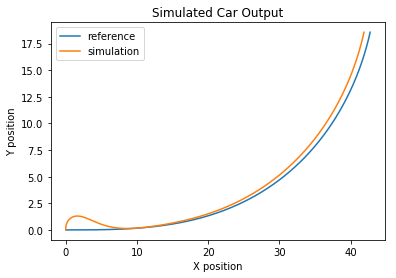

In [24]:
# Create plotting variables
# The simulation path plotting variables
sim_position = np.zeros((N+1,4))
for idx, pose in enumerate(sim_path):
	sim_position[idx,0] = pose.x
	sim_position[idx,1] = pose.y
	sim_position[idx,2], sim_position[idx,3] = linearProjectForward(pose, 1) 

# The reference path plotting variables
ref_position = np.zeros((N+1,2))
for idx, pose in enumerate(ref_path):
	ref_position[idx,0] = pose.x
	ref_position[idx,1] = pose.y
    
# Plot the reference path and simulated path
plt.figure()
plt.plot(ref_position[:,0], ref_position[:,1], label="reference")
plt.plot(sim_position[:,0], sim_position[:,1], label="simulation")
plt.title("Simulated Car Output")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.legend()
plt.show()

The car starts off with the wrong initial pose and has to correct to accurately follow the path.  Some error accumulates after a while because the controller is designed without any input from the x-position (this is a result of the linearization assumption).

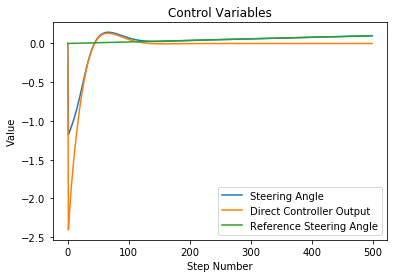

In [31]:
# Plot the steering angle applied to the car
plt.figure()
plt.plot(control_steer_angle, label="Steering Angle")
plt.plot(u_K_ar, label="Direct Controller Output")
plt.plot(ref_steer_ang, label="Reference Steering Angle")
plt.legend()
plt.title("Control Variables")
plt.xlabel("Step Number")
plt.ylabel("Value")
plt.show()

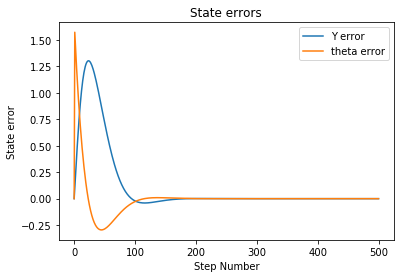

In [32]:
# Plot the state errors
plt.figure()
plt.plot(state_error[:,0], label="Y error")
plt.plot(state_error[:,1], label="theta error")
plt.title("State errors")
plt.xlabel("Step Number")
plt.ylabel("State error")
plt.legend()
plt.show()

This plot shows the state errors of the system.  Because of the linearization assumption, the x-position is not used in the controller output.  This means that the controller properly drives the states to 0; however, there will be some x-error that accumulates in the model.

In [38]:
# Create the animation
# Create the figure and axes
fig = plt.figure()
ax = plt.axes(xlim=(min(ref_position[:,0]), max(ref_position[:,0])), ylim=(min(ref_position[:,1]), max(ref_position[:,1])))

# Initialize plot items
reference_line, = ax.plot(ref_position[:,0], ref_position[:,1], label='Reference path')
car_line, = ax.plot([], [], label='Car', linewidth=5, color='k')
ax.legend()
plt.title('Simulated Path Following Car Model')

# Setup the axes to be 20% larger than the reference path
range_x = 1.2*(max(ref_position[:,0]) - min(ref_position[:,0])) # range of x
range_y = 1.2*(max(ref_position[:,1]) - min(ref_position[:,1])) # range of y
mean_x = (max(ref_position[:,0]) + min(ref_position[:,0])) / 2 # mean of x
mean_y = (max(ref_position[:,1]) + min(ref_position[:,1])) / 2 # mean of y
ax.set_xlim([mean_x - range_x/2, mean_x + range_x/2])
ax.set_ylim([mean_y - range_y/2, mean_y + range_y/2])

# Plot animation function
def animate(i):
    car_line.set_data([sim_position[i,0], sim_position[i,2]], 
    	[sim_position[i,1], sim_position[i,3]]) # car

    return car_line

# Create animation
car_animation = animation.FuncAnimation(fig, animate, N, interval=10)
rc('animation', html='html5')
car_animation